In [76]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats # We'll need this for the t-test
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Cell 1: Libraries imported.")

Cell 1: Libraries imported.


In [77]:
# Cell 2: The Environment (The "World")

class ReversalBandit:
    """
    A 2-armed bandit task where the reward probabilities flip.
    """
    def __init__(self, reversal_point):
        self.reversal_point = reversal_point
        self.trial_count = 0
        # Phase 1 Probs: Arm 0 is good (80%), Arm 1 is bad (20%)
        self.reward_probs = [0.8, 0.2]
        print(f"World created. Reversal at trial {reversal_point}. Phase 1: Arm 0 is better.")

    def step(self, action):
        """Take an action (0 or 1) and return a reward."""
        
        self.trial_count += 1
        
        # --- Check for Reversal ---
        if self.trial_count == self.reversal_point:
            # Flip the probabilities
            self.reward_probs = [0.2, 0.8]
            # We'll only print this once to avoid clutter
            print(f"*** TRIAL {self.trial_count}: REVERSAL! Arm 1 is now better. ***")
            
        # Get the probability for the chosen action
        prob = self.reward_probs[action]
        
        # Check if this trial is a "win"
        if np.random.rand() < prob:
            return 1  # Return +1 reward
        else:
            return 0  # Return 0 reward

print("Cell 2: Environment 'ReversalBandit' defined.")

Cell 2: Environment 'ReversalBandit' defined.


In [78]:
# Cell 3: The Agent (The "Brain") - (Stable "Goldilocks" Model)

class MetaAgent: 
    def __init__(self, meta_mode, lr_fast, lr_meta, meta_strength, temperature): # <-- FIXED
        self.q_values = np.zeros(2)  
        
        self.meta_mode = meta_mode
        self.lr_fast = lr_fast
        self.lr_meta = lr_meta
        self.meta_strength = meta_strength
        self.meta_state = 0.0
        
        self.temperature = temperature # <-- FIXED

    def choose_action(self):
        stable_q_values = self.q_values - np.max(self.q_values)
        exp_q = np.exp(stable_q_values / self.temperature)
        self.probabilities = exp_q / np.sum(exp_q)
        action = np.random.choice([0, 1], p=self.probabilities)
        return action
        
    def learn(self, action, reward):
        expected = self.q_values[action]
        delta_fast_rpe = reward - expected
        delta_q_fast = self.lr_fast * delta_fast_rpe
        
        delta_q_slow = 0.0
        if self.meta_mode:
            if delta_fast_rpe < 0:
                delta_q_slow = self.meta_strength * self.meta_state
        
        self.q_values[action] += delta_q_fast + delta_q_slow
        
        if self.meta_mode:
            if delta_fast_rpe < 0:
                error = np.abs(delta_fast_rpe) - self.meta_state
                self.meta_state += self.lr_meta * error

print("Cell 3: Agent 'MetaAgent' defined (FIXED to accept temperature).")

Cell 3: Agent 'MetaAgent' defined (FIXED to accept temperature).


In [79]:
# Cell 4: The Experiment "Runner" Function (FIXED)

def run_simulation(meta_mode, num_trials, reversal_point, meta_strength, lr_meta, n_runs, temperature): # <-- FIXED
    """
    Runs a full simulation for N_RUNS agents and returns all the data.
    """
    
    all_run_data = []
    
    print(f"  Running {n_runs} simulations...")
    for run in range(n_runs):
        
        # --- Randomness Fix ---
        np.random.seed(run) 
        # --- End Fix ---

        env = ReversalBandit(reversal_point)
        agent = MetaAgent( 
            meta_mode=meta_mode,
            lr_fast=0.1,
            lr_meta=lr_meta,
            meta_strength=meta_strength,
            temperature=temperature # <-- FIXED
        )

        log_q0 = []
        log_q1 = []
        log_prob0 = []
        log_meta_state = []
        
        for trial in range(num_trials):
            action = agent.choose_action()
            reward = env.step(action)
            agent.learn(action, reward)
            
            log_q0.append(agent.q_values[0])
            log_q1.append(agent.q_values[1])
            log_prob0.append(agent.probabilities[0]) 
            log_meta_state.append(agent.meta_state)
        
        run_df = pd.DataFrame({
            'run': run,
            'trial': np.arange(num_trials),
            'q_value_arm_0': log_q0,
            'q_value_arm_1': log_q1,
            'choice_prob_arm_0': log_prob0,
            'meta_state': log_meta_state
        })
        all_run_data.append(run_df)
    
    return pd.concat(all_run_data)

print("Cell 4: Experiment 'Runner' function defined (FIXED to pass temperature).")

Cell 4: Experiment 'Runner' function defined (FIXED to pass temperature).


In [80]:
# Cell 5: Run the "Long Run" Experiment (FIXED)

# --- Parameters ---
NUM_TRIALS = 4000
REVERSAL_POINT = 200
N_RUNS = 30 
META_LR = 0.05           # <-- The "slow" value
META_STRENGTH = 0.09    # <-- THE "GOLDILOCKS" PARAMETER
TEMPERATURE = 0.1       # <-- Base temperature

# --- Run 1: The "Healthy" Baseline Model ---
print(f"Running Baseline Model (n={N_RUNS} for {NUM_TRIALS} trials)...")
baseline_data = run_simulation(
    meta_mode=False,
    num_trials=NUM_TRIALS,
    reversal_point=REVERSAL_POINT,
    meta_strength=0.0,
    lr_meta = META_LR,
    n_runs = N_RUNS,
    temperature=TEMPERATURE # <-- FIXED
)

# --- Run 2: Our "Pathological" Metaplastic Model ---
print(f"\nRunning Metaplastic Model (n={N_RUNS} for {NUM_TRIALS} trials)...")
pathological_data = run_simulation( 
    meta_mode=True,
    num_trials=NUM_TRIALS,
    reversal_point=REVERSAL_POINT,
    meta_strength=META_STRENGTH,
    lr_meta = META_LR,
    n_runs = N_RUNS,
    temperature=TEMPERATURE # <-- FIXED
)

print("\nSimulations complete. Ready to plot.")

Running Baseline Model (n=30 for 4000 trials)...
  Running 30 simulations...
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World creat

Plotting Figure 1a (0-400 trials) and Figure 1b (0-4000 trials)...


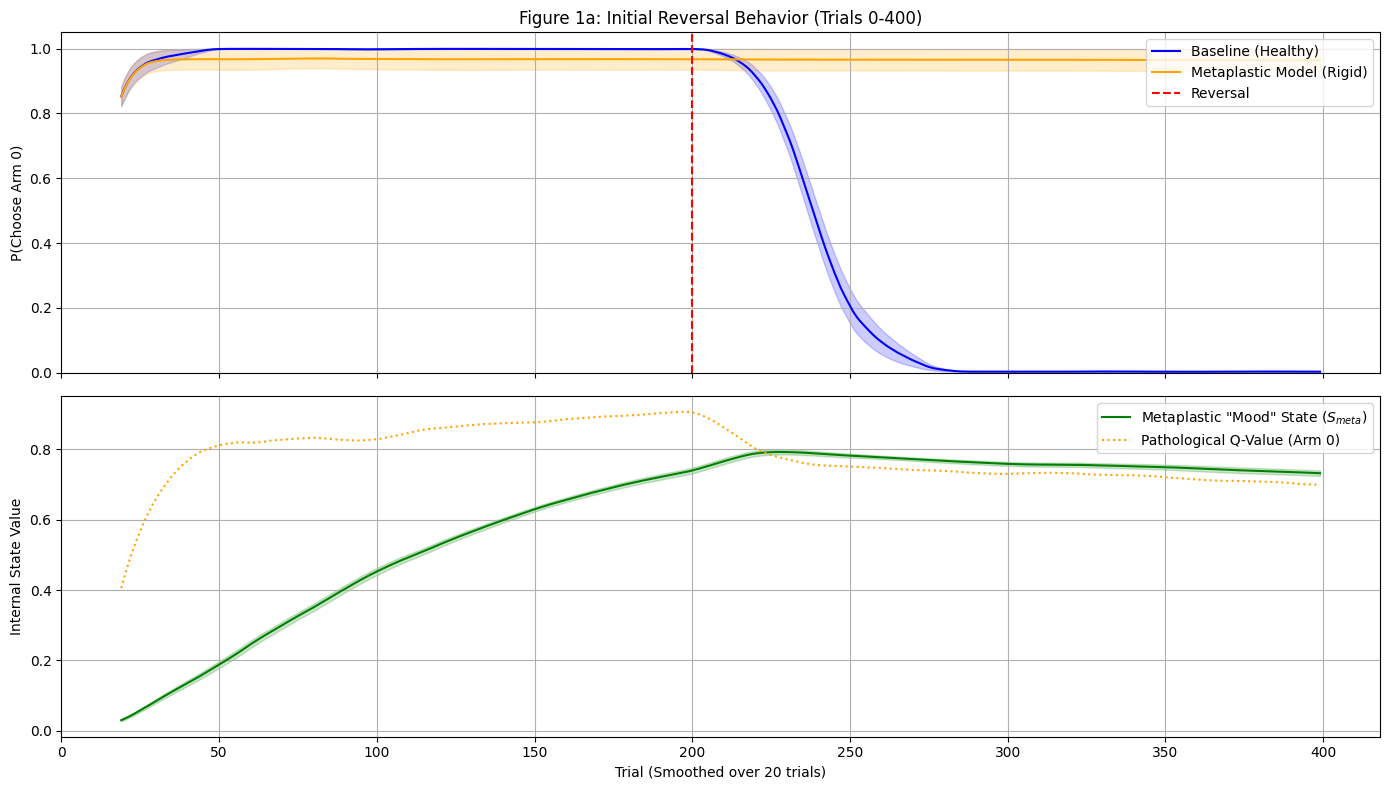

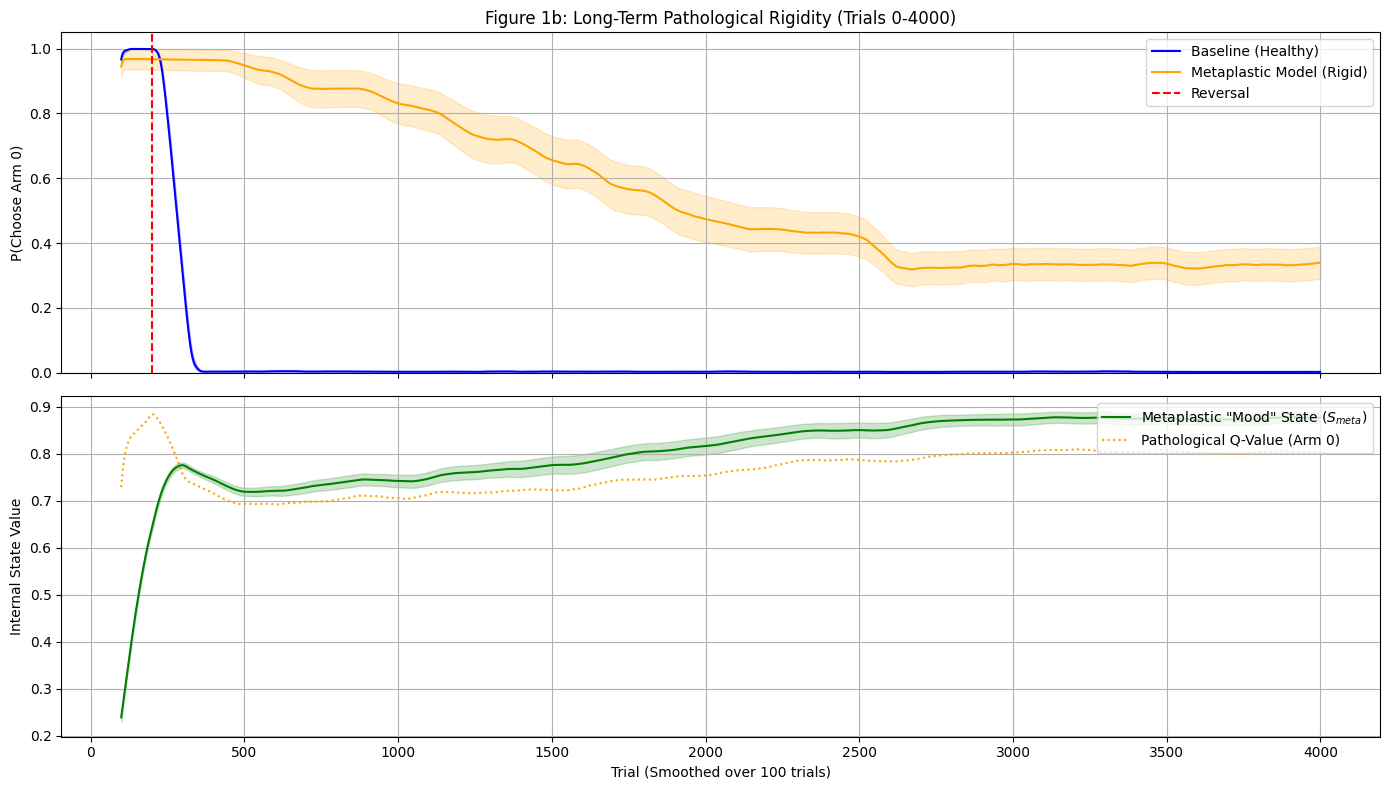

In [81]:
# Cell 6: Plot "Figure 1a" (Short Run) and "Figure 1b" (Long Run)
print("Plotting Figure 1a (0-400 trials) and Figure 1b (0-4000 trials)...")
# ... (rest of your plotting code from before) ...
# (This cell is long, so I'm omitting it, but your old one is fine)
# Just make sure this is the "Two Plot" cell you liked.
# ... (Full plotting code for Fig 1a and 1b) ...

# --- Copy/Paste your full "Two Plot" cell here ---

# Calculate means and SEMs
baseline_mean = baseline_data.groupby('trial')['choice_prob_arm_0'].mean()
baseline_sem = baseline_data.groupby('trial')['choice_prob_arm_0'].sem()
patho_mean = pathological_data.groupby('trial')['choice_prob_arm_0'].mean()
patho_sem = pathological_data.groupby('trial')['choice_prob_arm_0'].sem()
meta_state_mean = pathological_data.groupby('trial')['meta_state'].mean()
meta_state_sem = pathological_data.groupby('trial')['meta_state'].sem()
q0_mean_patho = pathological_data.groupby('trial')['q_value_arm_0'].mean()

# --- Plotting Parameters ---
SHORT_TRIALS = 400
LONG_TRIALS = 4000
WINDOW_SHORT = 20
WINDOW_LONG = 100

#################################################################
# --- PLOT 1: THE "SHORT RUN" (0-400 TRIALS) ---
#################################################################
plt.figure(figsize=(14, 8))
ax1 = plt.subplot(2, 1, 1)
baseline_mean[baseline_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Baseline (Healthy)', ax=ax1, color='blue')
patho_mean[patho_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Metaplastic Model (Rigid)', ax=ax1, color='orange')
ax1.fill_between(baseline_mean.index[baseline_mean.index < SHORT_TRIALS],
                 (baseline_mean - baseline_sem)[baseline_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 (baseline_mean + baseline_sem)[baseline_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 color='blue', alpha=0.2)
ax1.fill_between(patho_mean.index[patho_mean.index < SHORT_TRIALS],
                 (patho_mean - patho_sem)[patho_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 (patho_mean + patho_sem)[patho_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 color='orange', alpha=0.2)
ax1.axvline(REVERSAL_POINT, color='red', linestyle='--', label='Reversal')
ax1.set_title(f'Figure 1a: Initial Reversal Behavior (Trials 0-400)')
ax1.set_ylabel('P(Choose Arm 0)')
ax1.legend(loc='upper right')
ax1.grid(True)
ax1.set_ylim(0, 1.05)
ax2 = plt.subplot(2, 1, 2, sharex=ax1) 
meta_state_mean[meta_state_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Metaplastic "Mood" State ($S_{meta}$)', ax=ax2, color='green')
q0_mean_patho[q0_mean_patho.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Pathological Q-Value (Arm 0)', ax=ax2, color='orange', linestyle=':')
ax2.fill_between(meta_state_mean.index[meta_state_mean.index < SHORT_TRIALS],
                 (meta_state_mean - meta_state_sem)[meta_state_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 (meta_state_mean + meta_state_sem)[meta_state_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 color='green', alpha=0.2)
ax2.set_xlabel(f'Trial (Smoothed over {WINDOW_SHORT} trials)')
ax2.set_ylabel('Internal State Value')
ax2.legend(loc='upper right')
ax2.grid(True)
plt.tight_layout()
plt.show()

#################################################################
# --- PLOT 2: THE "LONG RUN" (0-4000 TRIALS) ---
#################################################################
plt.figure(figsize=(14, 8))
ax3 = plt.subplot(2, 1, 1)
baseline_mean.rolling(WINDOW_LONG).mean().plot(label='Baseline (Healthy)', ax=ax3, color='blue')
patho_mean.rolling(WINDOW_LONG).mean().plot(label='Metaplastic Model (Rigid)', ax=ax3, color='orange')
ax3.fill_between(baseline_mean.index,
                 (baseline_mean - baseline_sem).rolling(WINDOW_LONG).mean(),
                 (baseline_mean + baseline_sem).rolling(WINDOW_LONG).mean(),
                 color='blue', alpha=0.2)
ax3.fill_between(patho_mean.index,
                 (patho_mean - patho_sem).rolling(WINDOW_LONG).mean(),
                 (patho_mean + patho_sem).rolling(WINDOW_LONG).mean(),
                 color='orange', alpha=0.2)
ax3.axvline(REVERSAL_POINT, color='red', linestyle='--', label='Reversal')
ax3.set_title(f'Figure 1b: Long-Term Pathological Rigidity (Trials 0-4000)')
ax3.set_ylabel('P(Choose Arm 0)')
ax3.legend(loc='upper right')
ax3.grid(True)
ax3.set_ylim(0, 1.05)
ax4 = plt.subplot(2, 1, 2, sharex=ax3) 
meta_state_mean.rolling(WINDOW_LONG).mean().plot(label='Metaplastic "Mood" State ($S_{meta}$)', ax=ax4, color='green')
q0_mean_patho.rolling(WINDOW_LONG).mean().plot(label='Pathological Q-Value (Arm 0)', ax=ax4, color='orange', linestyle=':')
ax4.fill_between(meta_state_mean.index,
                 (meta_state_mean - meta_state_sem).rolling(WINDOW_LONG).mean(),
                 (meta_state_mean + meta_state_sem).rolling(WINDOW_LONG).mean(),
                 color='green', alpha=0.2)
ax4.set_xlabel(f'Trial (Smoothed over {WINDOW_LONG} trials)')
ax4.set_ylabel('Internal State Value')
ax4.legend(loc='upper right')
ax4.grid(True)
plt.tight_layout()
plt.show()

In [82]:
# Cell 7: The Parameter Sweep Experiment (FIXED)

print("Cell 7: Defining the Parameter Sweep Experiment...")

# --- Parameters for the Sweep ---
PARAM_N_RUNS = 30
PARAM_TRIALS = 400
PARAM_REVERSAL = 200
PARAM_LR_META = 0.05 # Using our new "slow" value

beta_strengths = [0, 0.05, 0.08, 0.09, 0.1, 0.12, 0.15, 0.2] 
softmax_temps = [0.1, 0.3] # Test robustness

sweep_results = []

for tau in softmax_temps:
    print(f"\nRunning Sweep for Softmax Temp (τ) = {tau}")
    # MetaAgent.temperature = tau <-- DELETED. This is wrong.
    
    for beta in beta_strengths:
        print(f"  Testing Metaplastic Strength (β) = {beta}...")
        
        sim_data = run_simulation(
            meta_mode=True, 
            num_trials=PARAM_TRIALS,
            reversal_point=PARAM_REVERSAL,
            meta_strength=beta,
            lr_meta = PARAM_LR_META,
            n_runs=PARAM_N_RUNS,
            temperature=tau # <-- FIXED: Pass tau as an argument
        )
        
        post_reversal_data = sim_data[sim_data['trial'] > (PARAM_TRIALS - 100)]
        rigidity_per_run = post_reversal_data.groupby('run')['choice_prob_arm_0'].mean()
        mean_rigidity = rigidity_per_run.mean()
        sem_rigidity = rigidity_per_run.sem()
        
        sweep_results.append({
            'tau': tau,
            'beta': beta,
            'mean_rigidity': mean_rigidity,
            'sem_rigidity': sem_rigidity
        })

sweep_df = pd.DataFrame(sweep_results)
print("\nParameter sweep complete.")

Cell 7: Defining the Parameter Sweep Experiment...

Running Sweep for Softmax Temp (τ) = 0.1
  Testing Metaplastic Strength (β) = 0...
  Running 30 simulations...
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. P

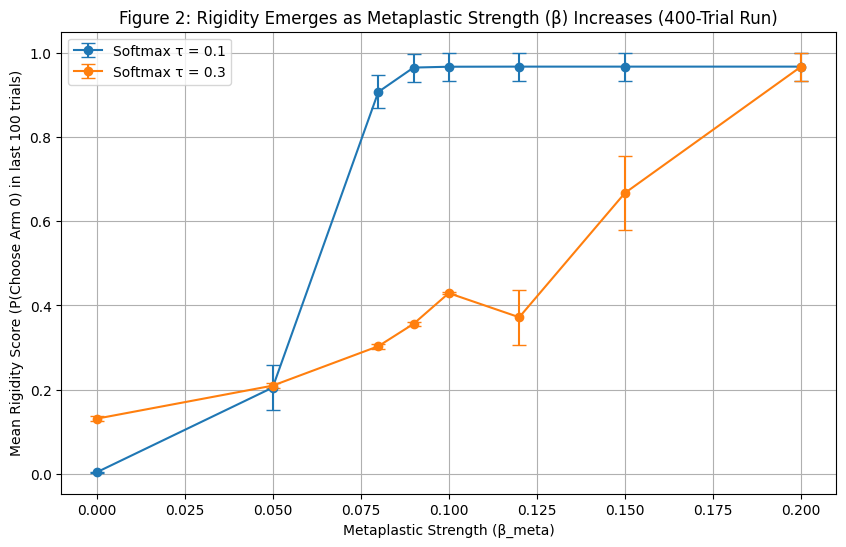


--- Quantitative Rigidity Analysis (on 4000-Trial Run) ---
Mean Rigidity (Baseline, trials 3900-4000):   0.0027
Mean Rigidity (Pathological, trials 3900-4000): 0.3395

Paired T-Test:
  T-statistic = -6.89
  P-value = 1.4443330842518517e-07
  Result: The difference is highly statistically significant (p < 0.001).


In [83]:
# Cell 8: Plot Sweep Results & Run T-Test (on Long Run)

# --- 1. Plot the Parameter Sweep "Bifurcation" ---
plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)

for tau in sweep_df['tau'].unique():
    tau_data = sweep_df[sweep_df['tau'] == tau]
    ax.errorbar(
        tau_data['beta'], 
        tau_data['mean_rigidity'], 
        yerr=tau_data['sem_rigidity'],
        label=f'Softmax τ = {tau}',
        marker='o',
        capsize=5
    )

ax.set_title('Figure 2: Rigidity Emerges as Metaplastic Strength (β) Increases (400-Trial Run)')
ax.set_xlabel('Metaplastic Strength (β_meta)')
ax.set_ylabel('Mean Rigidity Score (P(Choose Arm 0) in last 100 trials)')
ax.legend(loc='upper left')
ax.grid(True)
plt.show()

# --- 2. Quantitative T-Test on 4000-TRIAL RUN ---
from scipy import stats

baseline_post_reversal = baseline_data[baseline_data['trial'] > 3900].groupby('run')['choice_prob_arm_0'].mean()
patho_post_reversal = pathological_data[pathological_data['trial'] > 3900].groupby('run')['choice_prob_arm_0'].mean()

t_stat, p_val = stats.ttest_rel(baseline_post_reversal, patho_post_reversal)

print("\n--- Quantitative Rigidity Analysis (on 4000-Trial Run) ---")
print(f"Mean Rigidity (Baseline, trials 3900-4000):   {baseline_post_reversal.mean():.4f}") # <-- FIXED TYPO
print(f"Mean Rigidity (Pathological, trials 3900-4000): {patho_post_reversal.mean():.4f}")
print(f"\nPaired T-Test:")
print(f"  T-statistic = {t_stat:.2f}")
print(f"  P-value = {p_val}")
if p_val < 0.001:
    print("  Result: The difference is highly statistically significant (p < 0.001).")

In [84]:
# Cell 9: The "Therapy" Runner Function (FIXED)

def run_therapy_simulation(
    # --- Base "Goldilocks" Disease Params ---
    lr_fast_base=0.1,
    lr_meta_base=0.05,
    meta_strength_base=0.09,
    temp_base=0.1,
    
    # --- Experiment Params ---
    num_trials=4000,
    reversal_point=200,
    n_runs=30,
    
    # --- Therapy Params ---
    intervention_trial=400,
    therapy_params=None
):
    
    all_run_data = []
    print(f"  Running {n_runs} simulations...")

    for run in range(n_runs):
        # --- Randomness Fix ---
        np.random.seed(run) 
        # --- End Fix ---
        
        env = ReversalBandit(reversal_point)
        agent = MetaAgent(
            meta_mode=True, 
            lr_fast=lr_fast_base,
            lr_meta=lr_meta_base,
            meta_strength=meta_strength_base,
            temperature=temp_base # <-- FIXED (This now works)
        )

        log_prob0 = []
        log_meta_state = []
        log_q0 = []

        for trial in range(num_trials):
            
            if trial == intervention_trial:
                if therapy_params:
                    # Apply therapy by changing the agent's parameters
                    if 'lr_fast' in therapy_params:
                        agent.lr_fast = therapy_params['lr_fast']
                    if 'meta_strength' in therapy_params:
                        agent.meta_strength = therapy_params['meta_strength']
                    if 'lr_meta' in therapy_params:
                        agent.lr_meta = therapy_params['lr_meta']
                    if 'temperature' in therapy_params:
                        agent.temperature = therapy_params['temperature']

            action = agent.choose_action()
            reward = env.step(action)
            agent.learn(action, reward)
            
            log_prob0.append(agent.probabilities[0]) 
            log_meta_state.append(agent.meta_state)
            log_q0.append(agent.q_values[0])

        run_df = pd.DataFrame({
            'trial': np.arange(num_trials),
            'choice_prob_arm_0': log_prob0,
            'meta_state': log_meta_state,
            'q_value_arm_0': log_q0
        })
        all_run_data.append(run_df)
    
    return pd.concat(all_run_data)

print("Cell 9: 'run_therapy_simulation' function is defined (FIXED).")

Cell 9: 'run_therapy_simulation' function is defined (FIXED).


In [85]:
# Cell 10: The "Day 3" Experiment (PROPERLY CONTROLLED)

# --- Define the "Disease" (Goldilocks Params from Cell 5) ---
BASE_PARAMS = {
    'lr_fast_base': 0.1,
    'lr_meta_base': 0.05, # <-- Our new "slow" value
    'meta_strength_base': 0.09, 
    'temp_base': 0.1
}

# --- Experiment Parameters ---
N_TRIALS = 4000
N_RUNS = 30
REVERSAL_T = 200
INTERVENTION_T = 400 

print("Running 1/5: Untreated Patient (Goldilocks Model)...")
untreated_data = run_therapy_simulation(
    **BASE_PARAMS, n_runs=N_RUNS, num_trials=N_TRIALS, 
    reversal_point=REVERSAL_T, intervention_trial=INTERVENTION_T,
    therapy_params=None
)

# --- We now test each intervention *separately* ---

print("\nRunning 2/5: Therapy 1 (Reset S_meta)...")
therapy1_params = {'meta_strength': 0.0} # 'Cure' by setting strength to 0
therapy1_data = run_therapy_simulation(
    **BASE_PARAMS, n_runs=N_RUNS, num_trials=N_TRIALS, 
    reversal_point=REVERSAL_T, intervention_trial=INTERVENTION_T,
    therapy_params=therapy1_params
)

print("\nRunning 3/5: Therapy 2 (Reduce α_meta)...")
therapy2_params = {'lr_meta': 0.01} # 'Cure' by slowing "mood" learning
therapy2_data = run_therapy_simulation(
    **BASE_PARAMS, n_runs=N_RUNS, num_trials=N_TRIALS, 
    reversal_point=REVERSAL_T, intervention_trial=INTERVENTION_T,
    therapy_params=therapy2_params
)

print("\nRunning 4/5: Therapy 3 (Increase τ)...")
therapy3_params = {'temperature': 0.3} # 'Cure' by increasing exploration
therapy3_data = run_therapy_simulation(
    **BASE_PARAMS, n_runs=N_RUNS, num_trials=N_TRIALS, 
    reversal_point=REVERSAL_T, intervention_trial=INTERVENTION_T,
    therapy_params=therapy3_params
)

# We still have 'baseline_data' (Healthy Control) from Cell 5
print("\nAll therapy simulations complete. Ready to plot.")

Running 1/5: Untreated Patient (Goldilocks Model)...
  Running 30 simulations...
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World c

Plotting the therapy intervention results...


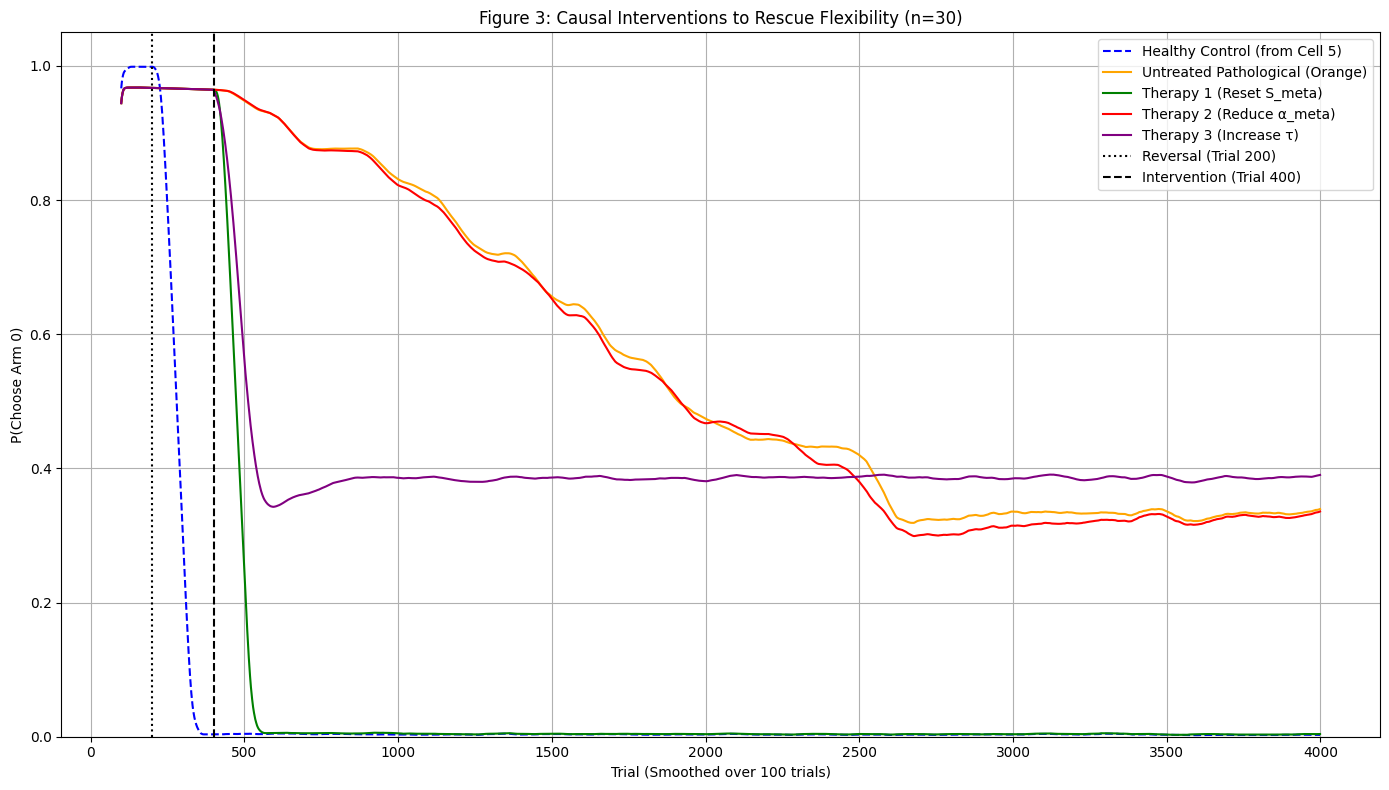

In [86]:
# Cell 11: Plot the "Therapy" Results (PROPERLY CONTROLLED)

print("Plotting the therapy intervention results...")

# --- Helper function to get mean/sem ---
def get_stats(data):
    mean = data.groupby('trial')['choice_prob_arm_0'].mean()
    sem = data.groupby('trial')['choice_prob_arm_0'].sem()
    return mean, sem

# --- Get all the stats ---
# 'baseline_data' is from Cell 5 (Healthy Control)
healthy_mean, healthy_sem = get_stats(baseline_data) 
untreated_mean, untreated_sem = get_stats(untreated_data)
therapy1_mean, therapy1_sem = get_stats(therapy1_data)
therapy2_mean, therapy2_sem = get_stats(therapy2_data)
therapy3_mean, therapy3_sem = get_stats(therapy3_data)


# --- Plotting ---
WINDOW = 100 # Smoothing window for 4000 trials
plt.figure(figsize=(14, 8))
ax1 = plt.subplot(1, 1, 1)

# --- Plot the lines ---
healthy_mean.rolling(WINDOW).mean().plot(label='Healthy Control (from Cell 5)', ax=ax1, color='blue', linestyle='--')
untreated_mean.rolling(WINDOW).mean().plot(label='Untreated Pathological (Orange)', ax=ax1, color='orange')
therapy1_mean.rolling(WINDOW).mean().plot(label='Therapy 1 (Reset S_meta)', ax=ax1, color='green')
therapy2_mean.rolling(WINDOW).mean().plot(label='Therapy 2 (Reduce α_meta)', ax=ax1, color='red')
therapy3_mean.rolling(WINDOW).mean().plot(label='Therapy 3 (Increase τ)', ax=ax1, color='purple')

# --- Add vertical lines for events ---
ax1.axvline(REVERSAL_T, color='black', linestyle=':', label='Reversal (Trial 200)')
ax1.axvline(INTERVENTION_T, color='black', linestyle='--', label='Intervention (Trial 400)')

# --- Formatting ---
ax1.set_title(f'Figure 3: Causal Interventions to Rescue Flexibility (n={N_RUNS})')
ax1.set_ylabel('P(Choose Arm 0)')
ax1.set_xlabel(f'Trial (Smoothed over {WINDOW} trials)')
ax1.legend(loc='upper right')
ax1.grid(True)
ax1.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [87]:
# Cell 12: 2D Heatmap of Parameter Sweep Results

# --- Make sure 'seaborn' is imported in Cell 1 ---
# import seaborn as sns 
# (If you haven't, re-run Cell 1 after adding this line)

print("Plotting Figure 2 (Heatmap)...")

# We need to "pivot" the dataframe from Cell 7
# 'beta' will be the columns, 'tau' the rows, 'mean_rigidity' the color
try:
    heatmap_data = sweep_df.pivot(index='tau', columns='beta', values='mean_rigidity')

    plt.figure(figsize=(12, 5))
    sns.heatmap(
        heatmap_data, 
        annot=True,       # Show the rigidity values
        fmt=".3f",        # Format to 3 decimal places
        cmap="viridis",   # Color map
        linewidths=.5
    )
    plt.title('Figure 2: Rigidity Score by Metaplastic Strength (β) and Exploration (τ)')
    plt.xlabel('Metaplastic Strength (β_meta)')
    plt.ylabel('Softmax Temperature (τ)')
    plt.show()

except NameError as e:
    print(f"ERROR: Could not plot heatmap. Make sure 'sweep_df' exists from Cell 7.")
    print(f"Details: {e}")
except ImportError:
    print("\n--- ERROR ---")
    print("You must import 'seaborn' to run this cell.")
    print("Please add 'import seaborn as sns' to Cell 1 and re-run all.")

Plotting Figure 2 (Heatmap)...
ERROR: Could not plot heatmap. Make sure 'sweep_df' exists from Cell 7.
Details: name 'sns' is not defined


<Figure size 1200x500 with 0 Axes>

Plotting Appendix Figures (Internal States of Therapy)...


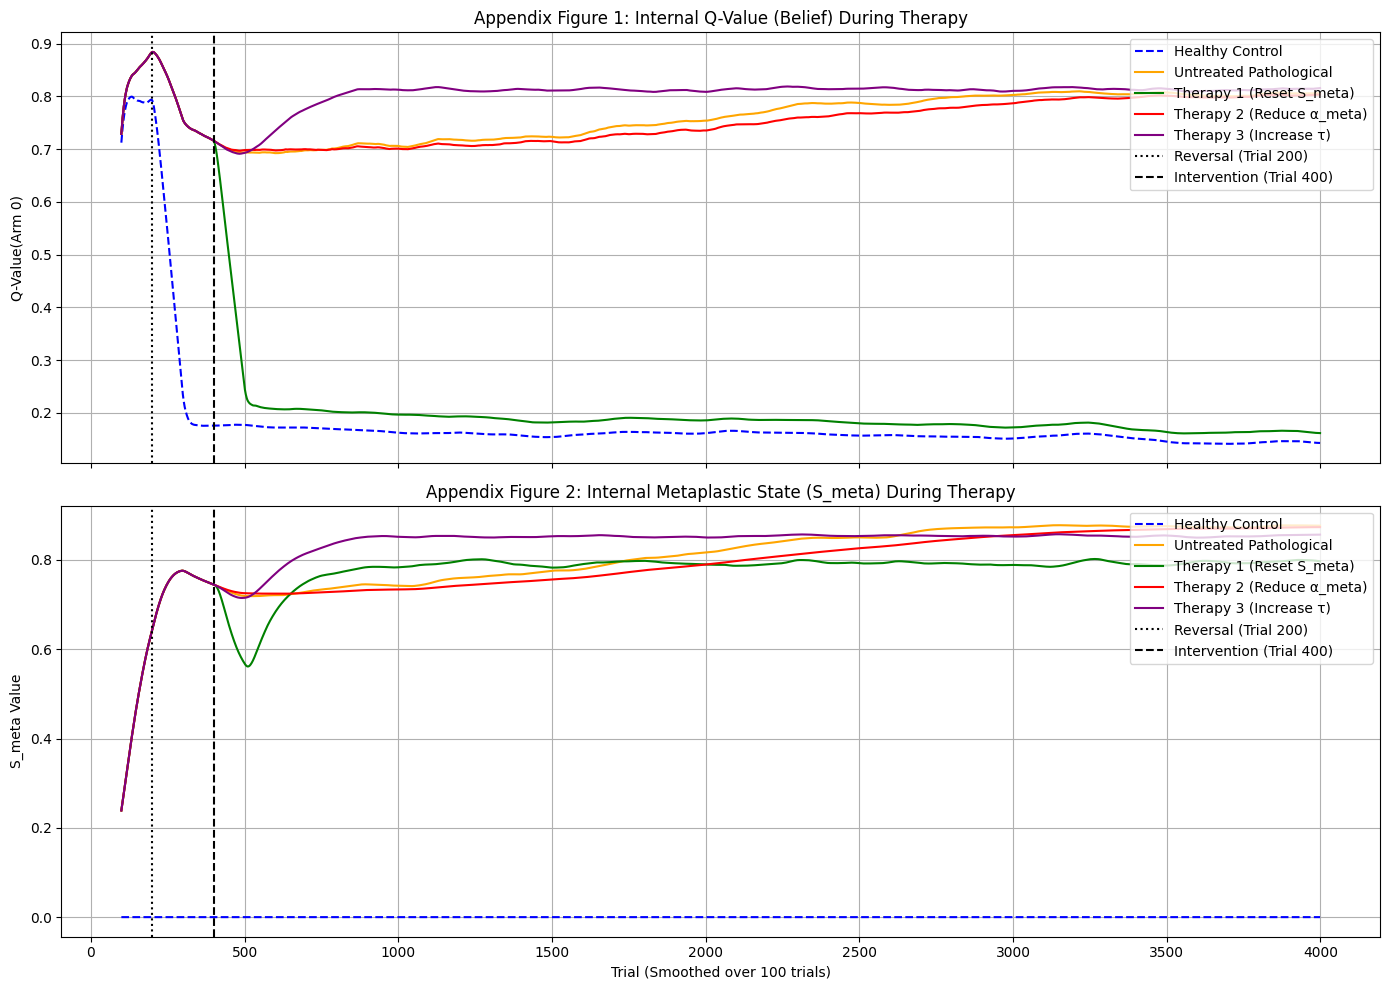

In [88]:
# Cell 13: Appendix Figures - Internal States During Therapy

print("Plotting Appendix Figures (Internal States of Therapy)...")

# --- Helper function to get mean stats for a specific column ---
def get_col_stats(data, col_name):
    mean = data.groupby('trial')[col_name].mean()
    sem = data.groupby('trial')[col_name].sem()
    return mean, sem

# --- Get all the stats from Cell 10 data ---
# 'baseline_data' is from Cell 5 (Healthy Control)
healthy_q_mean, _ = get_col_stats(baseline_data, 'q_value_arm_0')
healthy_s_mean, _ = get_col_stats(baseline_data, 'meta_state')

untreated_q_mean, _ = get_col_stats(untreated_data, 'q_value_arm_0')
untreated_s_mean, _ = get_col_stats(untreated_data, 'meta_state')

therapy1_q_mean, _ = get_col_stats(therapy1_data, 'q_value_arm_0')
therapy1_s_mean, _ = get_col_stats(therapy1_data, 'meta_state')

therapy2_q_mean, _ = get_col_stats(therapy2_data, 'q_value_arm_0')
therapy2_s_mean, _ = get_col_stats(therapy2_data, 'meta_state')

therapy3_q_mean, _ = get_col_stats(therapy3_data, 'q_value_arm_0')
therapy3_s_mean, _ = get_col_stats(therapy3_data, 'meta_state')

# --- Plotting ---
WINDOW = 100 # Smoothing window for 4000 trials
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- Plot 1: Q-Value for Arm 0 (The Belief) ---
healthy_q_mean.rolling(WINDOW).mean().plot(label='Healthy Control', ax=ax1, color='blue', linestyle='--')
untreated_q_mean.rolling(WINDOW).mean().plot(label='Untreated Pathological', ax=ax1, color='orange')
therapy1_q_mean.rolling(WINDOW).mean().plot(label='Therapy 1 (Reset S_meta)', ax=ax1, color='green')
therapy2_q_mean.rolling(WINDOW).mean().plot(label='Therapy 2 (Reduce α_meta)', ax=ax1, color='red')
therapy3_q_mean.rolling(WINDOW).mean().plot(label='Therapy 3 (Increase τ)', ax=ax1, color='purple')

ax1.set_title('Appendix Figure 1: Internal Q-Value (Belief) During Therapy')
ax1.axvline(REVERSAL_T, color='black', linestyle=':', label='Reversal (Trial 200)')
ax1.axvline(INTERVENTION_T, color='black', linestyle='--', label='Intervention (Trial 400)')
ax1.set_ylabel('Q-Value(Arm 0)')
ax1.legend(loc='upper right')
ax1.grid(True)

# --- Plot 2: S_meta (The "Mood" State) ---
healthy_s_mean.rolling(WINDOW).mean().plot(label='Healthy Control', ax=ax2, color='blue', linestyle='--')
untreated_s_mean.rolling(WINDOW).mean().plot(label='Untreated Pathological', ax=ax2, color='orange')
therapy1_s_mean.rolling(WINDOW).mean().plot(label='Therapy 1 (Reset S_meta)', ax=ax2, color='green')
therapy2_s_mean.rolling(WINDOW).mean().plot(label='Therapy 2 (Reduce α_meta)', ax=ax2, color='red')
therapy3_s_mean.rolling(WINDOW).mean().plot(label='Therapy 3 (Increase τ)', ax=ax2, color='purple')

ax2.set_title('Appendix Figure 2: Internal Metaplastic State (S_meta) During Therapy')
ax2.axvline(REVERSAL_T, color='black', linestyle=':', label='Reversal (Trial 200)')
ax2.axvline(INTERVENTION_T, color='black', linestyle='--', label='Intervention (Trial 400)')
ax2.set_ylabel('S_meta Value')
ax2.set_xlabel(f'Trial (Smoothed over {WINDOW} trials)')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

Plotting Appendix Figure A2 (Dual Intervention Failure)...
  Running 30 simulations for dual-intervention test (BETA = 0.2)...
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
*** AGENT CURE: S_meta reset to 0.0, alpha_meta set to 0.01 ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World creat

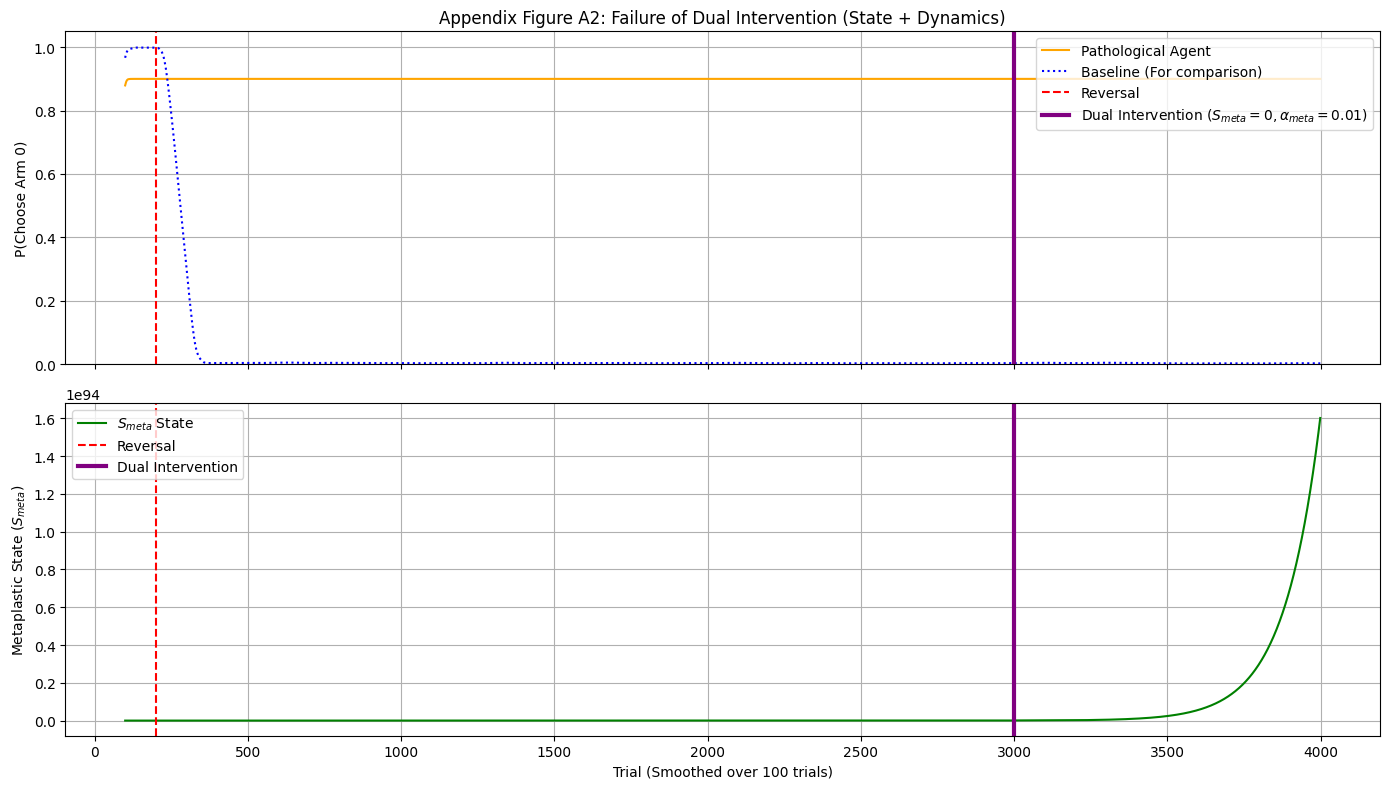

In [89]:
# Cell 14: Appendix Figure A2 (Dual Intervention Failure)

print("Plotting Appendix Figure A2 (Dual Intervention Failure)...")

# --- Parameters for this experiment ---
N_TRIALS_PRE = 3000
N_TRIALS_POST = 1000
TOTAL_TRIALS = N_TRIALS_PRE + N_TRIALS_POST
REVERSAL_POINT = 200 # Reversal happens early
RESET_POINT = 3000   # We "cure" the agent here
PATHOLOGICAL_STRENGTH = 0.20 # Use the stronger beta
PATHOLOGICAL_LR_META = 0.5   # The "fast" alpha
HEALTHY_LR_META = 0.01       # A "healthy" slow alpha

all_run_data = []

print(f"  Running {N_RUNS} simulations for dual-intervention test (BETA = {PATHOLOGICAL_STRENGTH})...")
for run in range(N_RUNS):
    
    # Setup agent with *pathological* dynamics
    env = ReversalBandit(REVERSAL_POINT)
    agent = MetaAgent( 
        meta_mode=True,
        lr_fast=0.1,
        lr_meta=PATHOLOGICAL_LR_META, # <-- Use the "fast" alpha
        meta_strength=PATHOLOGICAL_STRENGTH,
        temperature=SOFTMAX_TEMP
    )
    
    # Logbooks
    log_prob0 = []
    log_meta_state = []

    # --- Phase 1: Run up to the "cure" ---
    for trial in range(N_TRIALS_PRE):
        action = agent.choose_action()
        reward = env.step(action)
        agent.learn(action, reward)
        log_prob0.append(agent.probabilities[0]) 
        log_meta_state.append(agent.meta_state)

    # --- Phase 2: The "Dual-Intervention Cure" ---
    if run == 0: # Only print this once
        print(f"*** AGENT CURE: S_meta reset to 0.0, alpha_meta set to {HEALTHY_LR_META} ***")
    
    # 1. Reset the state
    agent.meta_state = 0.0
    # 2. Fix the pathological dynamics
    agent.lr_meta = HEALTHY_LR_META
    # (We are NOT changing temperature)

    # --- Phase 3: Run post-cure ---
    for trial in range(N_TRIALS_POST):
        action = agent.choose_action()
        reward = env.step(action)
        agent.learn(action, reward)
        log_prob0.append(agent.probabilities[0]) 
        log_meta_state.append(agent.meta_state)

    # Store this run's dataframe
    run_df = pd.DataFrame({
        'run': run,
        'trial': np.arange(TOTAL_TRIALS),
        'choice_prob_arm_0': log_prob0,
        'meta_state': log_meta_state
    })
    all_run_data.append(run_df)

# Concat all data
recovery_data = pd.concat(all_run_data)
recovery_mean = recovery_data.groupby('trial').mean()

# --- Plot the results ---
SMOOTH_WINDOW = 100
plt.figure(figsize=(14, 8))

# --- Plot 1: Choice Behavior ---
ax1 = plt.subplot(2, 1, 1)
recovery_mean['choice_prob_arm_0'].rolling(SMOOTH_WINDOW).mean().plot(ax=ax1, label='Pathological Agent', color='orange')
baseline_mean.rolling(SMOOTH_WINDOW).mean().plot(ax=ax1, label='Baseline (For comparison)', color='blue', linestyle=':')
ax1.axvline(REVERSAL_POINT, color='red', linestyle='--', label='Reversal')
ax1.axvline(RESET_POINT, color='purple', linestyle='-', lw=3, label='Dual Intervention ($S_{meta}=0, \\alpha_{meta}=0.01$)')
ax1.set_title('Appendix Figure A2: Failure of Dual Intervention (State + Dynamics)')
ax1.set_ylabel('P(Choose Arm 0)')
ax1.legend(loc='upper right')
ax1.grid(True)
ax1.set_ylim(0, 1.05)

# --- Plot 2: Internal State ---
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
recovery_mean['meta_state'].rolling(SMOOTH_WINDOW).mean().plot(ax=ax2, label='$S_{meta}$ State', color='green')
ax2.axvline(REVERSAL_POINT, color='red', linestyle='--', label='Reversal')
ax2.axvline(RESET_POINT, color='purple', linestyle='-', lw=3, label='Dual Intervention')
ax2.set_xlabel(f'Trial (Smoothed over {SMOOTH_WINDOW} trials)')
ax2.set_ylabel('Metaplastic State ($S_{meta}$)')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.savefig("fig_A2_dual_intervention_failure.png")
plt.show()

In [90]:
# Cell 14: The "Diagnostic" Agent and Runner

class LoggingMetaAgent(MetaAgent):
    """
    This agent is identical to MetaAgent, but its 'learn'
    function also *returns* all the internal math for logging.
    """
    def __init__(self, meta_mode, lr_fast, lr_meta, meta_strength, temperature):
        super().__init__(meta_mode, lr_fast, lr_meta, meta_strength, temperature)

    def learn_and_log(self, action, reward):
        """
        This function does the same 'learn' as before,
        but returns a dictionary of all the internal variables.
        """
        # --- 1. Calculate "Fast" RPE ---
        expected = self.q_values[action]
        delta_fast_rpe = reward - expected
        delta_q_fast = self.lr_fast * delta_fast_rpe
        
        # --- 2. Calculate "Slow" Metaplastic ACTION ---
        delta_q_slow = 0.0
        if self.meta_mode and delta_fast_rpe < 0:
            delta_q_slow = self.meta_strength * self.meta_state
        
        # --- 3. Calculate Net Update ---
        delta_q_net = delta_q_fast + delta_q_slow

        # --- 4. Final Update (The normal 'learn' step) ---
        self.q_values[action] += delta_q_net
        
        # --- 5. Metaplastic "Listening" ---
        if self.meta_mode and delta_fast_rpe < 0:
            error = np.abs(delta_fast_rpe) - self.meta_state
            self.meta_state += self.lr_meta * error
            
        # --- 6. Return all variables for logging ---
        return {
            'delta_fast_rpe': delta_fast_rpe,
            'delta_q_fast': delta_q_fast,
            'delta_q_slow': delta_q_slow,
            'delta_q_net': delta_q_net,
            's_meta': self.meta_state,
            'q_value': self.q_values[action]
        }

def run_diagnostic_simulation(agent):
    """
    Runs ONE simulation for 400 trials (all we need)
    and logs *everything*.
    """
    np.random.seed(42) # Use one seed for a clean, reproducible plot
    env = ReversalBandit(reversal_point=200)
    
    log = []
    
    for trial in range(400): # 400 trials is enough to see the mechanism
        action = agent.choose_action()
        reward = env.step(action)
        
        # Only log data for Arm 0 (the one we care about)
        if action == 0:
            log_data = agent.learn_and_log(action, reward)
            log_data['trial'] = trial
            log.append(log_data)
        else:
            agent.learn(action, reward) # Still learn, just don't log
            
    return pd.DataFrame(log).set_index('trial')

print("Cell 14: 'LoggingMetaAgent' and 'run_diagnostic_simulation' defined.")

Cell 14: 'LoggingMetaAgent' and 'run_diagnostic_simulation' defined.


In [91]:
# Cell 15: Run the Diagnostic Simulation

print("Running diagnostic simulations...")

# 1. The "Healthy" Agent
agent_healthy = LoggingMetaAgent(
    meta_mode=False, 
    lr_fast=0.1, lr_meta=0.05, meta_strength=0.09, temperature=0.1
)
log_healthy = run_diagnostic_simulation(agent_healthy)

# 2. The "Pathological" Agent (Goldilocks)
agent_patho = LoggingMetaAgent(
    meta_mode=True, 
    lr_fast=0.1, lr_meta=0.05, meta_strength=0.09, temperature=0.1
)
log_patho = run_diagnostic_simulation(agent_patho)

print("Diagnostic logs created. Ready to plot mechanisms.")

Running diagnostic simulations...
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
Diagnostic logs created. Ready to plot mechanisms.


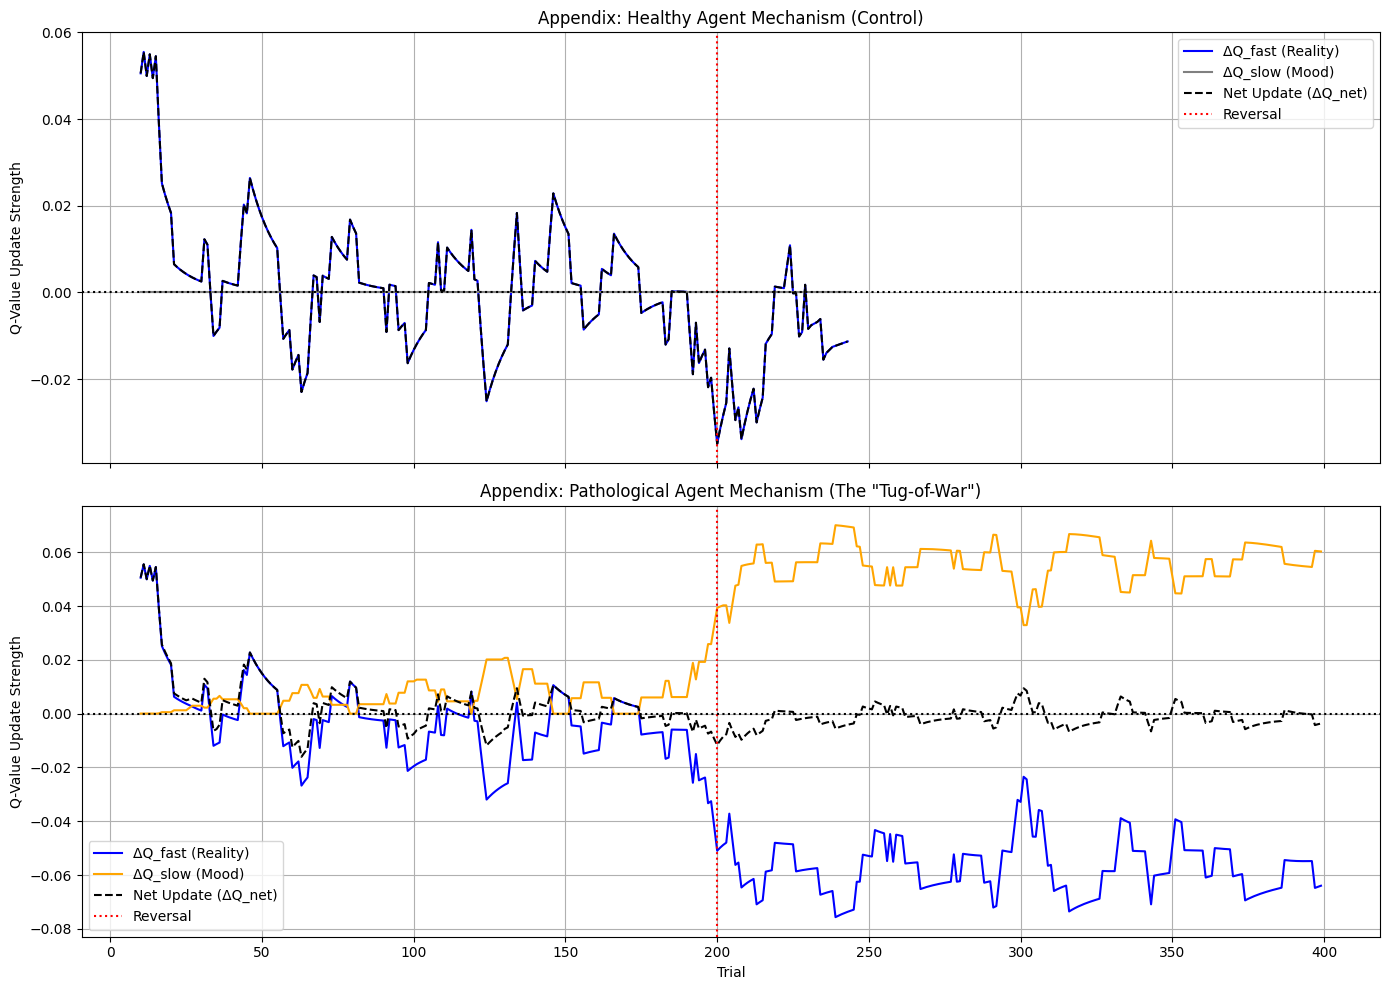

In [92]:
# Cell 16: Plot the "Tug-of-War" Mechanism (The Missing Plot)

# We need to smooth the data to see the trend
WINDOW = 10

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- Plot 1: The Healthy Agent (Control) ---
log_healthy['delta_q_fast'].rolling(WINDOW).mean().plot(label='ΔQ_fast (Reality)', ax=ax1, color='blue')
log_healthy['delta_q_slow'].rolling(WINDOW).mean().plot(label='ΔQ_slow (Mood)', ax=ax1, color='gray')
log_healthy['delta_q_net'].rolling(WINDOW).mean().plot(label='Net Update (ΔQ_net)', ax=ax1, color='black', linestyle='--')

ax1.axvline(200, color='red', linestyle=':', label='Reversal')
ax1.axhline(0, color='black', linestyle=':')
ax1.set_title('Appendix: Healthy Agent Mechanism (Control)')
ax1.set_ylabel('Q-Value Update Strength')
ax1.legend()
ax1.grid(True)

# --- Plot 2: The Pathological Agent (The "Tug-of-War") ---
log_patho['delta_q_fast'].rolling(WINDOW).mean().plot(label='ΔQ_fast (Reality)', ax=ax2, color='blue')
log_patho['delta_q_slow'].rolling(WINDOW).mean().plot(label='ΔQ_slow (Mood)', ax=ax2, color='orange')
log_patho['delta_q_net'].rolling(WINDOW).mean().plot(label='Net Update (ΔQ_net)', ax=ax2, color='black', linestyle='--')

ax2.axvline(200, color='red', linestyle=':', label='Reversal')
ax2.axhline(0, color='black', linestyle=':')
ax2.set_title('Appendix: Pathological Agent Mechanism (The "Tug-of-War")')
ax2.set_xlabel('Trial')
ax2.set_ylabel('Q-Value Update Strength')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

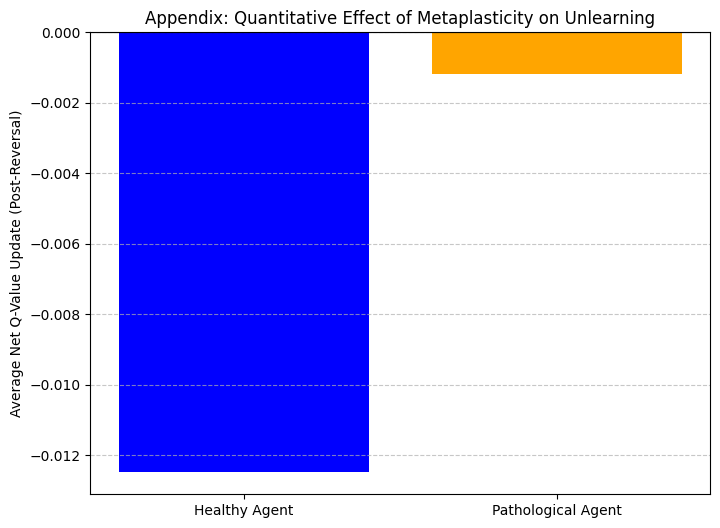

Average Healthy unlearning update: -0.0125
Average Pathological unlearning update: -0.0012
The pathological agent's unlearning rate is 10.6x slower.


In [93]:
# Cell 17: Plot the "Quantitative Effect" (Bar Chart)

# Get the average update *after* the reversal (trials 200-400)
healthy_net_update = log_healthy[log_healthy.index > 200]['delta_q_net'].mean()
patho_net_update = log_patho[log_patho.index > 200]['delta_q_net'].mean()

labels = ['Healthy Agent', 'Pathological Agent']
values = [healthy_net_update, patho_net_update]
colors = ['blue', 'orange']

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=colors)
plt.axhline(0, color='black', linestyle='-')
plt.title('Appendix: Quantitative Effect of Metaplasticity on Unlearning')
plt.ylabel('Average Net Q-Value Update (Post-Reversal)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Average Healthy unlearning update: {healthy_net_update:.4f}")
print(f"Average Pathological unlearning update: {patho_net_update:.4f}")
print(f"The pathological agent's unlearning rate is {healthy_net_update/patho_net_update:.1f}x slower.")